## Analyzing AI and Cloud Computing Trends Through GitHub Repository Data to Cut Through Hype

### TLDR



*   Growth is linear, not exponential
*   Microsoft Azure, OpenAI and Amazon packages dominate
*   Anthropic shows most growth, all other packages appear anemic



### Introduction


This study leverages GitHub repository creation data to analyze adoption trends in AI and cloud computing technologies. By examining repository creation patterns, we aim to provide an empirical perspective on technology adoption rates, potentially challenging prevailing market narratives.


Note that this approach is built on the assumption that new repositories containing specific python packages in their names correlate with their growth and adoption. Google Cloud formerly enabled querying of code within pages but appears to have disabled this, therefore this leaves the repo names as queryable. While imperfect, this method provides a unique lens to examine and challenge prevailing market narratives.


In [1]:
# Install packages
!pip install -q pandas seaborn matplotlib google-cloud-bigquery

In [2]:
# Imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from google.cloud import bigquery
from google.oauth2 import service_account

Only possible to query GitHub using the Google Cloud Platform (GCP) and BigQuery to access and query the GitHub data archive.

In [ ]:
# Replace this with your path to your GCP service account and connect to biq query
key_path = "/home/jb/gcp_keys/gh_query-a1b2c3d4e5f6.json"
credentials = service_account.Credentials.from_service_account_file(key_path)
client = bigquery.Client(credentials=credentials, project=credentials.project_id)

To extract the data at the dates we need, the following SQL query extracts relevant data from the GitHub archive by categorizing repositories related to specific AI and cloud technologies, and aggregates repository creation counts by creation month.  Important to note that the package definition is the key, so modify as you wish.

In [3]:
query = """
WITH ai_repos AS (
  SELECT
    repo.name AS repo_name,
    EXTRACT(DATE FROM created_at) AS creation_date,
    CASE
      WHEN LOWER(repo.name) LIKE '%bedrock%' THEN 'bedrock'
      WHEN LOWER(repo.name) LIKE '%vertex%' THEN 'vertex'
      WHEN LOWER(repo.name) LIKE '%openai%' THEN 'openai'
      WHEN LOWER(repo.name) LIKE '%anthropic%' THEN 'anthropic'
      WHEN LOWER(repo.name) LIKE '%langchain%' THEN 'langchain'
      WHEN LOWER(repo.name) LIKE '%azure%' THEN 'azure'
      WHEN LOWER(repo.name) LIKE '%llamaindex%' THEN 'llamaindex'
      WHEN LOWER(repo.name) LIKE '%neo4j%' THEN 'neo4j'
      WHEN LOWER(repo.name) LIKE '%pymongo%' THEN 'pymongo'
      WHEN LOWER(repo.name) LIKE '%elasticsearch%' THEN 'elasticsearch'
      WHEN LOWER(repo.name) LIKE '%boto3%' THEN 'boto3'
      WHEN LOWER(repo.name) LIKE '%ayx%' THEN 'ayx'
      WHEN LOWER(repo.name) LIKE '%snowflake-connector-python%' THEN 'snowflake'
      WHEN LOWER(repo.name) LIKE '%c3-toolset%' THEN 'c3ai'
      WHEN LOWER(repo.name) LIKE '%dataiku-api-client%' THEN 'dataiku'
      WHEN LOWER(repo.name) LIKE '%salesforce-einstein-vision-python%' THEN 'salesforce_einstein'
      WHEN LOWER(repo.name) LIKE '%qlik-py-tools%' THEN 'qlik'
      WHEN LOWER(repo.name) LIKE '%palantir-foundry-client%' THEN 'palantir_foundry'
      WHEN LOWER(repo.name) LIKE '%cuda-python%' THEN 'nvidia_cuda'
      WHEN LOWER(repo.name) LIKE '%openvino%' THEN 'intel_openvino'
      WHEN LOWER(repo.name) LIKE '%clarifai%' THEN 'clarifai'
      WHEN LOWER(repo.name) LIKE '%twilio%' THEN 'twilio'
      WHEN LOWER(repo.name) LIKE '%oracleai%' THEN 'oracle_ai'
      ELSE 'other'
    END AS keyword_category
  FROM
    `githubarchive.day.20*`
  WHERE
    _TABLE_SUFFIX >= '240101'
    AND _TABLE_SUFFIX NOT LIKE '%view%'
    AND type = 'CreateEvent'
    AND repo.name IS NOT NULL
    AND (
      LOWER(repo.name) LIKE '%bedrock%'
      OR LOWER(repo.name) LIKE '%vertex%'
      OR LOWER(repo.name) LIKE '%openai%'
      OR LOWER(repo.name) LIKE '%anthropic%'
      OR LOWER(repo.name) LIKE '%langchain%'
      OR LOWER(repo.name) LIKE '%azure%'
      OR LOWER(repo.name) LIKE '%llamaindex%'
      OR LOWER(repo.name) LIKE '%neo4j%'
      OR LOWER(repo.name) LIKE '%pymongo%'
      OR LOWER(repo.name) LIKE '%elasticsearch%'
      OR LOWER(repo.name) LIKE '%boto3%'
      OR LOWER(repo.name) LIKE '%ayx%'
      OR LOWER(repo.name) LIKE '%snowflake-connector-python%'
      OR LOWER(repo.name) LIKE '%c3-toolset%'
      OR LOWER(repo.name) LIKE '%dataiku-api-client%'
      OR LOWER(repo.name) LIKE '%salesforce-einstein-vision-python%'
      OR LOWER(repo.name) LIKE '%qlik-py-tools%'
      OR LOWER(repo.name) LIKE '%palantir-foundry-client%'
      OR LOWER(repo.name) LIKE '%cuda-python%'
      OR LOWER(repo.name) LIKE '%openvino%'
      OR LOWER(repo.name) LIKE '%clarifai%'
      OR LOWER(repo.name) LIKE '%twilio%'
      OR LOWER(repo.name) LIKE '%oracleai%'
    )
)

SELECT
  FORMAT_DATE('%Y-%m', creation_date) AS month,
  keyword_category,
  COUNT(DISTINCT repo_name) AS new_repo_count
FROM
  ai_repos
GROUP BY
  month, keyword_category
ORDER BY
  month, keyword_category
  """

Read in the data...

In [ ]:
# Read in the data
df = client.query(query).to_dataframe()
df.head()

,month,keyword_category,new_repo_count
0,2024-01,anthropic,16
1,2024-01,ayx,337
2,2024-01,azure,8594
3,2024-01,bedrock,381
4,2024-01,boto3,81


Then transform the query results into a pandas DataFrame and create a time series for each technology, facilitating comparative analysis.

In [ ]:
df_pivot = df.pivot(index='month', columns='keyword_category', values='new_repo_count')
df_pivot.sort_index(inplace=True)

Visualize the data:

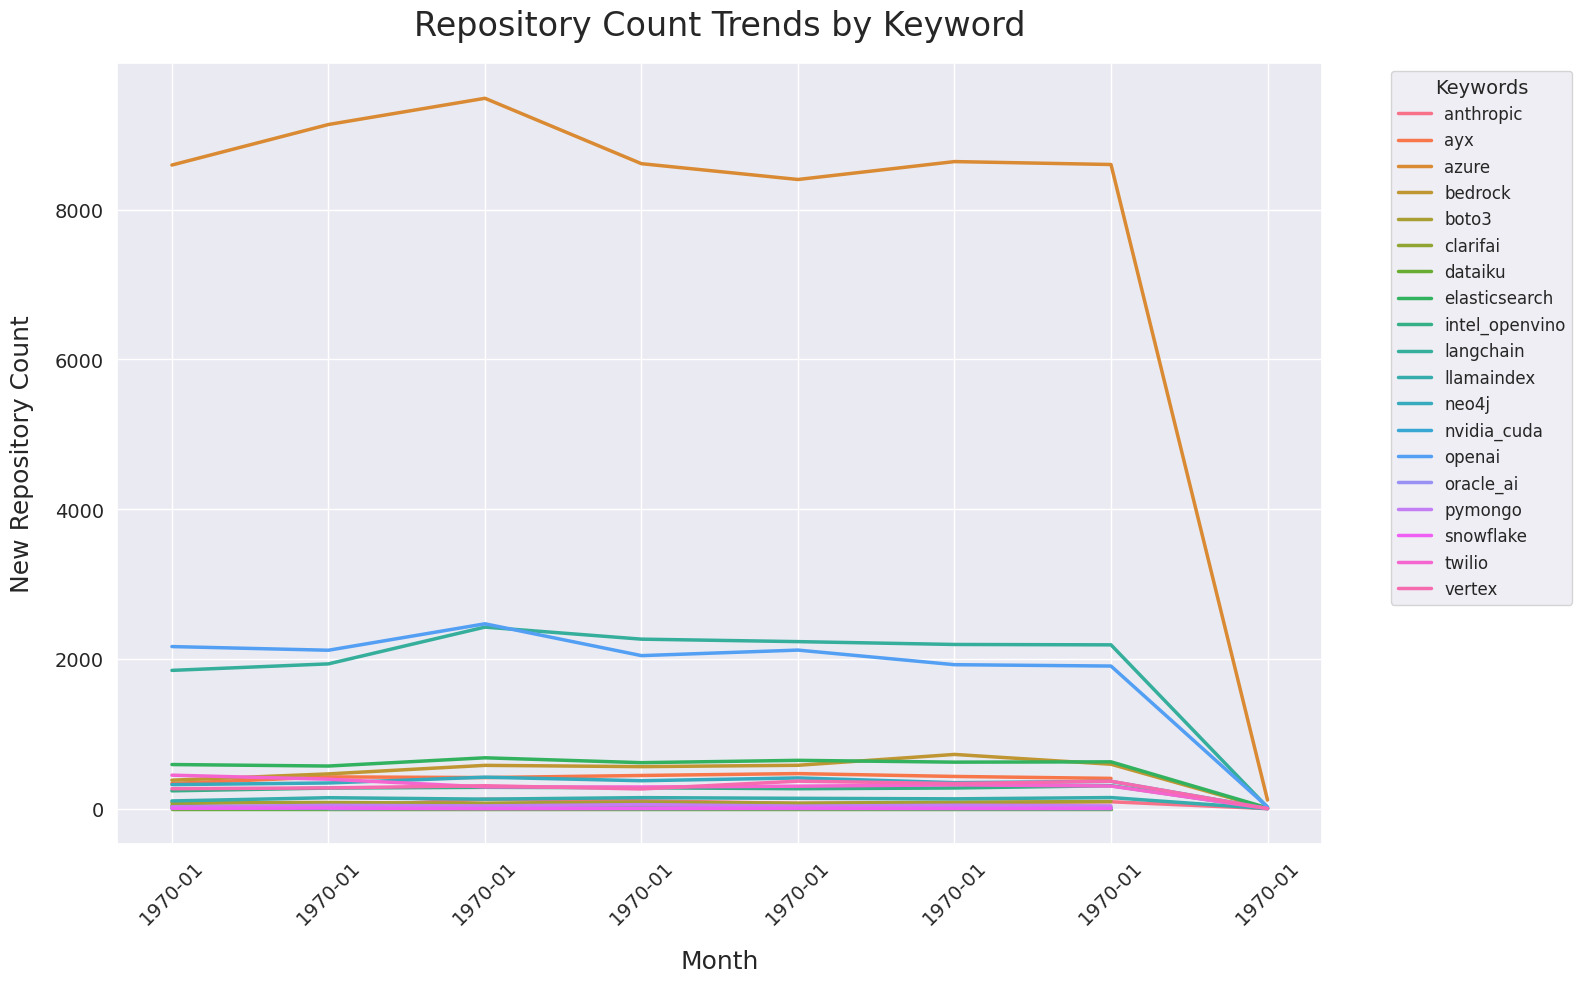

In [ ]:
# Set up the plot
plt.figure(figsize=(16, 10))
sns.set(style="darkgrid")

# Create a color palette
colors = sns.color_palette("husl", n_colors=len(df_pivot.columns))

# Plot each keyword as a line
for keyword, color in zip(df_pivot.columns, colors):
    sns.lineplot(data=df_pivot, x=df_pivot.index, y=keyword, linewidth=2.5, color=color, label=keyword)

# Customize the plot
plt.title("Repository Count Trends by Keyword", fontsize=24, pad=20)
plt.xlabel("Month", fontsize=18, labelpad=15)
plt.ylabel("New Repository Count", fontsize=18, labelpad=15)
plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)

# Format x-axis to show dates nicely
plt.gca().xaxis.set_major_formatter(DateFormatter("%Y-%m"))

# Adjust legend
plt.legend(fontsize=12, title="Keywords", title_fontsize=14, bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout to prevent cutoff
plt.tight_layout()

# Show the plot
plt.show()

Months are messed up from the wrong data... fixing this and moving the Azure package to its own axis on the right..!

In [ ]:
# Fix the month
df['month'] = pd.to_datetime(df['month'])

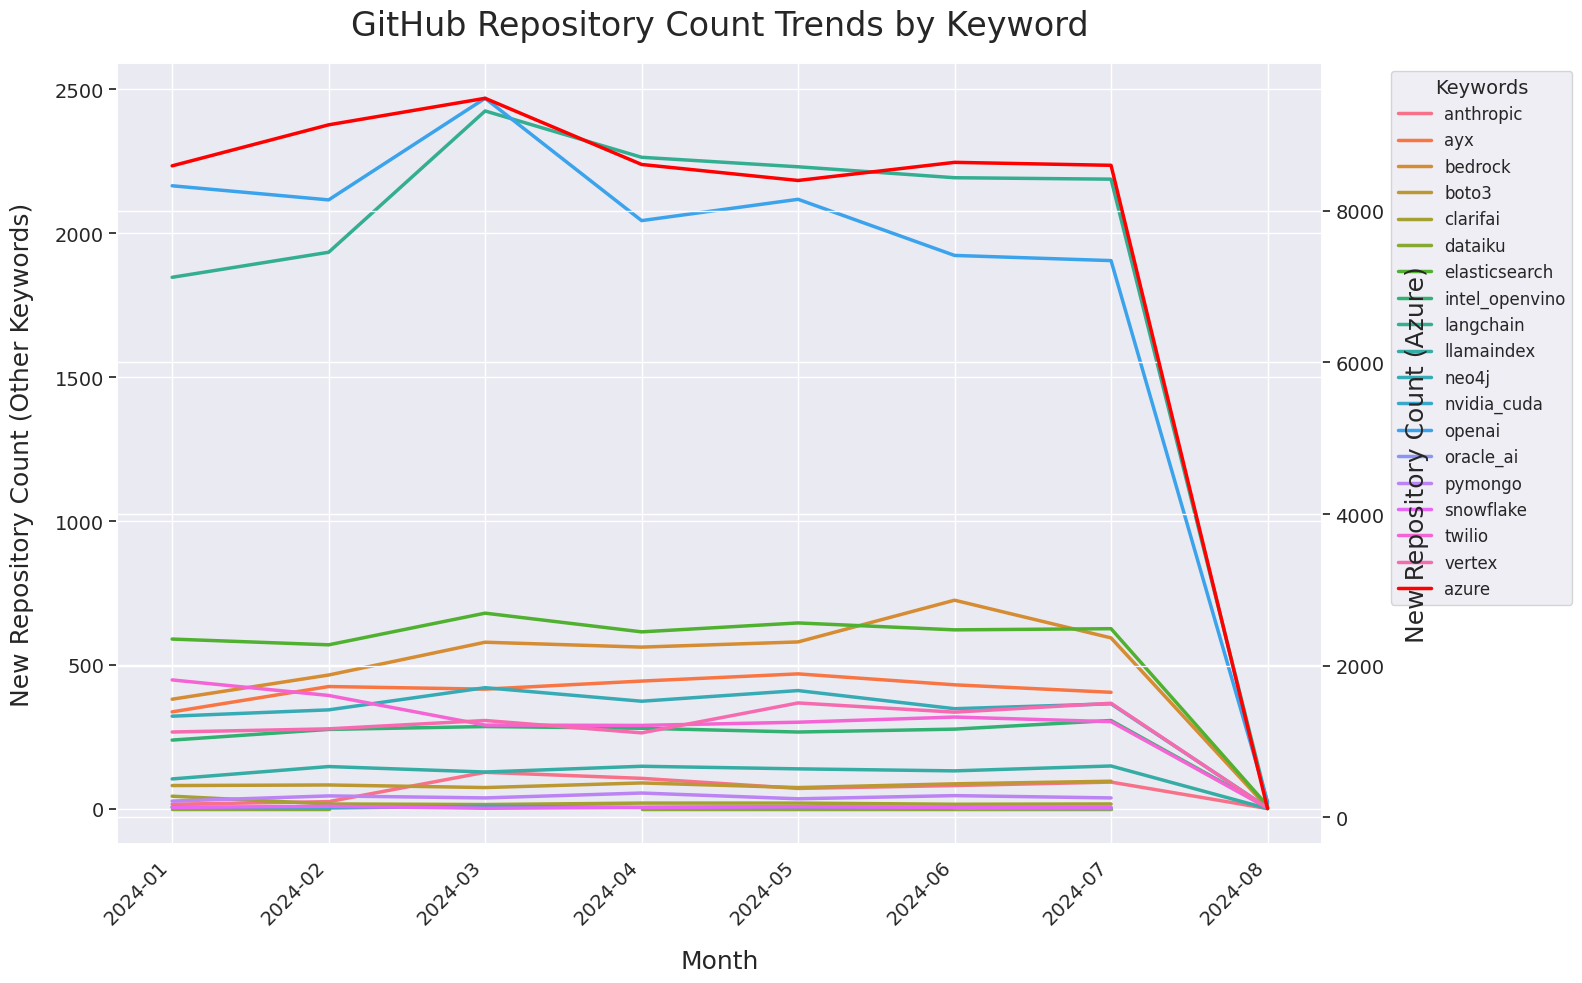

In [ ]:
# Sort the index to ensure chronological order
df_pivot.sort_index(inplace=True)

# Set up the plot
fig, ax1 = plt.subplots(figsize=(16, 10))
ax2 = ax1.twinx()
sns.set(style="darkgrid")

# Create a color palette
colors = sns.color_palette("husl", n_colors=len(df_pivot.columns) - 1)  # -1 for 'azure'

# Plot each keyword as a line, excluding 'azure'
for keyword, color in zip([col for col in df_pivot.columns if col != 'azure'], colors):
    ax1.plot(df_pivot.index, df_pivot[keyword], linewidth=2.5, color=color, label=keyword)

# Plot 'azure' on the secondary axis
if 'azure' in df_pivot.columns:
    ax2.plot(df_pivot.index, df_pivot['azure'], linewidth=2.5, color='red', label='azure')

# Customize the plot
ax1.set_title("GitHub Repository Count Trends by Keyword", fontsize=24, pad=20)
ax1.set_xlabel("Month", fontsize=18, labelpad=15)
ax1.set_ylabel("New Repository Count (Other Keywords)", fontsize=18, labelpad=15)
ax2.set_ylabel("New Repository Count (Azure)", fontsize=18, labelpad=15)

# Format x-axis to show dates nicely
ax1.set_xticks(range(len(df_pivot.index)))
ax1.set_xticklabels(df_pivot.index, rotation=45, ha='right')

# Adjust tick label font sizes
ax1.tick_params(axis='both', which='major', labelsize=14)
ax2.tick_params(axis='both', which='major', labelsize=14)

# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, fontsize=12, title="Keywords", title_fontsize=14, bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout to prevent cutoff
plt.tight_layout()

# Show the plot
plt.show()

Now removing the last month and the top ranked packages for visibility into the scale

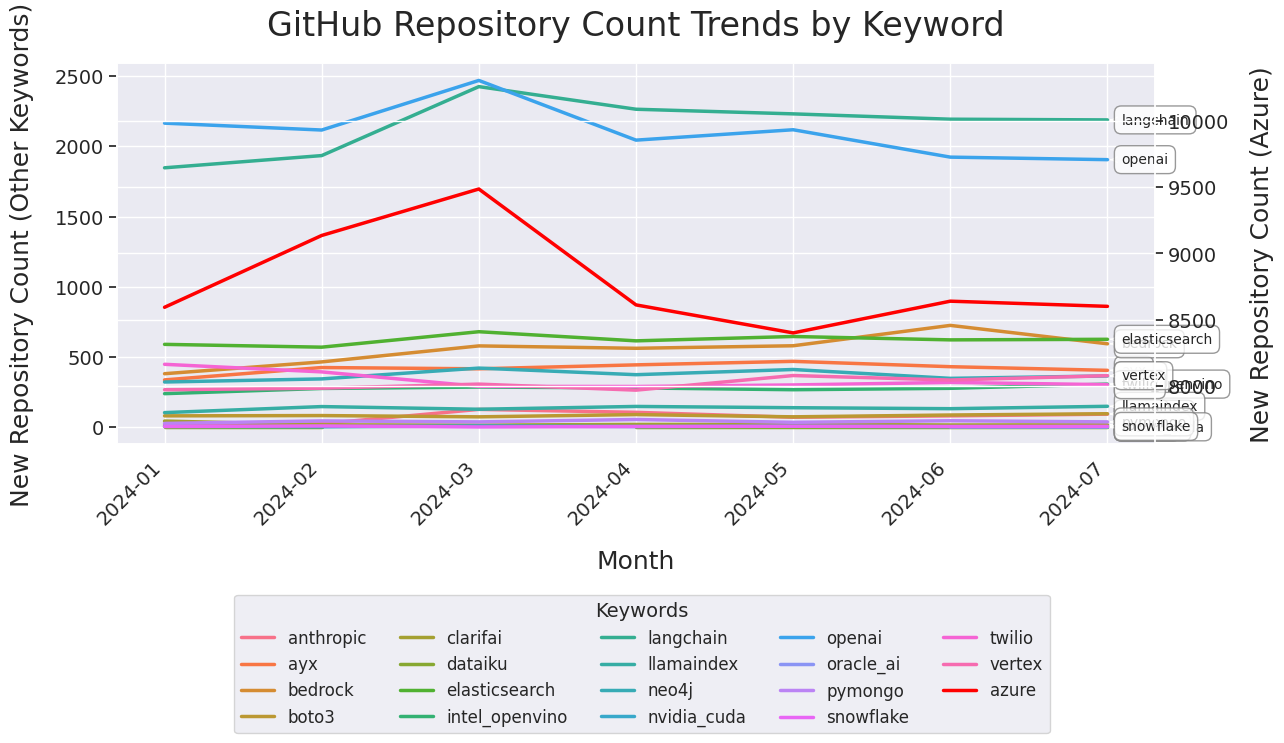

In [ ]:
# Sort the index to ensure chronological order and remove the last month
df_pivot = df.pivot(index='month', columns='keyword_category', values='new_repo_count')
df_pivot.sort_index(inplace=True)
df_pivot = df_pivot.iloc[:-1]

# Set up the plot
fig, ax1 = plt.subplots(figsize=(13, 6))
ax2 = ax1.twinx()
sns.set(style="darkgrid")

# Create a color palette
colors = sns.color_palette("husl", n_colors=len(df_pivot.columns) - 1)  # -1 for 'azure'

# Plot each keyword as a line, excluding 'azure'
for keyword, color in zip([col for col in df_pivot.columns if col != 'azure'], colors):
    ax1.plot(df_pivot.index, df_pivot[keyword], linewidth=2.5, color=color, label=keyword)


# Plot 'azure' on the secondary axis
if 'azure' in df_pivot.columns:
    azure_line = ax2.plot(df_pivot.index, df_pivot['azure'], linewidth=2.5, color='red', label='azure')

    # Adjust the scale of the secondary axis
    ax2.set_ylim(df_pivot['azure'].min() * 0.9, df_pivot['azure'].max() * 1.1)

# Customize the plot
ax1.set_title("GitHub Repository Count Trends by Keyword", fontsize=24, pad=20)
ax1.set_xlabel("Month", fontsize=18, labelpad=15)
ax1.set_ylabel("New Repository Count (Other Keywords)", fontsize=18, labelpad=15)
ax2.set_ylabel("New Repository Count (Azure)", fontsize=18, labelpad=15)

# Format x-axis to show dates nicely
ax1.set_xticks(range(len(df_pivot.index)))
ax1.set_xticklabels(df_pivot.index, rotation=45, ha='right')

# Adjust tick label font sizes
ax1.tick_params(axis='both', which='major', labelsize=14)
ax2.tick_params(axis='both', which='major', labelsize=14)

for keyword in df_pivot.columns:
    ax1.annotate(keyword, (df_pivot.index[-1], df_pivot[keyword].iloc[-1]),
                xytext=(10, 0), textcoords='offset points',
                fontsize=10, va='center', ha='left',
                bbox=dict(boxstyle='round,pad=0.5', fc='white', ec='gray', alpha=0.8),
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

# Combine legends and place it below the plot
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
fig.legend(lines1 + lines2, labels1 + labels2, fontsize=12, title="Keywords", title_fontsize=14,
           loc='lower center', bbox_to_anchor=(0.5, -0.25), ncol=5)

# Adjust layout to prevent cutoff and make room for the legend
plt.subplots_adjust(bottom=0.2)

# Show the plot
plt.tight_layout()
plt.show()


**Noteworthy trends:**

* Azure repository creation demonstrates a linear growth pattern, contrasting with the exponential growth narrative often presented in corporate communications.

* The exclusion of dominant players (OpenAI and Amazon) in visualizations allows for a more nuanced examination of emerging technologies and their relative adoption rates eg. Anthropic's recent growth.


**Limitations and Future Work:**

* Repository creation may not directly translate to production use or market share.
* The analysis may not capture private repositories or enterprise adoption patterns not reflected in public GitHub data.
* The categorization method based on repository names may introduce some misclassification.